# CPSC 330 Lecture 11

#### Lecture plan

- 👋
- **Turn on recording**
- Announcements
- True/False from last class (10 min)
- Ensembling with regression (5 min)
- Prediction intervals (20 min)
- Break (5 min)
- Feature importances: linear regression (15 min)
- Feature importances: beyond linear models (25 min)

Piazza:

- T/F questions 


In [94]:
import numpy as np
import pandas as pd
import scipy.stats

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import normalize, scale, Normalizer, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import r2_score, mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [32]:
from utils import cross_validate_std

In [15]:
plt.rcParams['font.size'] = 16

In [16]:
def mape(true, pred):
    """
    Compute the Mean Absolute Percent Error (MAPE)
    given true target values and predictions.    
    """
    return 100.*np.mean(np.abs((pred - true)/true))

## Announcements

- 2nd half of Lecture 10 recording was lost
- I re-recorded and posted on course README (not Canvas)

## Data processing code from last class

In [25]:
df = pd.read_csv("data/housing.csv", index_col=0)

df_train, df_test = train_test_split(df, random_state=123)

X_train = df_train.drop(columns=['SalePrice'])
y_train = df_train['SalePrice']

X_test = df_test.drop(columns=['SalePrice'])
y_test = df_test['SalePrice']

In [20]:
numeric_features     = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 
                        'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                        'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
                        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                        'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 
                        'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
                        'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold']
ordinal_features_reg = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                        'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
ordinal_features_oth = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                        'Functional',  'Fence']
categorical_features = list(set(X_train.columns) - set(numeric_features) - set(ordinal_features_reg))

ordering = ['Po', 'Fa', 'TA', 'Gd', 'Ex']

In [21]:
numeric_preprocessing = make_pipeline(SimpleImputer(strategy='median'), 
                                      StandardScaler())
ordinal_preprocessing = make_pipeline(SimpleImputer(strategy='most_frequent'), 
                                      OrdinalEncoder(categories=[ordering]*len(ordinal_features_reg)))
categorical_preprocessing = make_pipeline(SimpleImputer(strategy='constant', fill_value="?"),
                                          OneHotEncoder(handle_unknown='ignore', sparse=False))

In [24]:
preprocessing = ColumnTransformer([
    ('numeric', numeric_preprocessing, numeric_features),
    ('ordinal', ordinal_preprocessing, ordinal_features_reg),
    ('categorical', categorical_preprocessing, categorical_features)
])

## Ensembling with Regression (5 min)


- Last week we talked about ensembles. 
- There are regression analogues of the ensemble methods we covered.
  - `VotingClassifier` -> `VotingRegressor`
  - `StackingClassifier` -> `StackingRegressor`
- There are also regression analogues for the fancy trees, e.g. `XGBRegressor`. 

In [30]:
regressors = {
    'linear regression' : make_pipeline(preprocessing, Ridge()),
    'decision tree' : make_pipeline(preprocessing, DecisionTreeRegressor()),
    'random forest' : make_pipeline(preprocessing, RandomForestRegressor(n_estimators=10, random_state=999)),
    'XGBoost' : make_pipeline(preprocessing, XGBRegressor(random_state=999)) 
}

In [33]:
results_dict = {name: cross_validate_std(regressor, X_train, y_train, return_train_score=True) for name, regressor in regressors.items()}

In [45]:
results_df = pd.DataFrame(results_dict).T.sort_values(by=["test_score"], ascending=False)
results_df

,fit_time,score_time,test_score,train_score,std_test_score,std_train_score
random forest,0.182600,0.013029,0.827948,0.972232,0.047029,0.002553
XGBoost,0.368894,0.016650,0.821373,0.999903,0.059844,0.000018
decision tree,0.063465,0.012196,0.726004,1.000000,0.053089,0.000000
linear regression,0.065610,0.015640,0.725838,0.928608,0.174656,0.004207


Let's try averaging:

In [35]:
averaging_model = VotingRegressor(list(regressors.items()))

In [36]:
averaging_model.fit(X_train, y_train);

In [37]:
cross_validate_std(averaging_model, X_train, y_train, return_train_score=True)

fit_time           0.755703
score_time         0.060219
test_score         0.834211
train_score        0.990643
std_test_score     0.054098
std_train_score    0.000385
dtype: float64

Let's look at how the predictions are generated:

In [38]:
averaging_model.predict(X_test[:1])[0]

223671.7927756227

In [39]:
r = {name : regressor.predict(X_test[:1])[0] for name, regressor in averaging_model.named_estimators_.items()}
r = pd.DataFrame(r, index=["Prediction"]).T
r

,Prediction
linear regression,222545.436727
decision tree,215000.000000
random forest,228940.000000
XGBoost,228201.734375


In [40]:
r.mean()

Prediction    223671.792776
dtype: float64

- Note the prediction above is exactly the average of these 4 predictions. 
- Contrast with hard/soft voting from the classification case.

For Stacking, our meta-model is now `Ridge` instead of `LogisticRegression` by default:

In [41]:
stacking_model = StackingRegressor(list(regressors.items()))

In [42]:
stacking_model.fit(X_train, y_train);

In [43]:
cross_validate_std(stacking_model, X_train, y_train, return_train_score=True)

fit_time           4.351770
score_time         0.067070
test_score         0.814530
train_score        0.989827
std_test_score     0.085418
std_train_score    0.012465
dtype: float64

- Above: this appears to do worse, but the std is very high, presumably due to the very small dataset.
- We should probably (at least) do a lot more folds if we want to feel more confident.

As with classification, we can again look at the coefficients of the meta-model, because it's still a linear model:

In [44]:
pd.DataFrame(data=stacking_model.final_estimator_.coef_, index=regressors.keys(), columns=["Coefficient"])

,Coefficient
linear regression,0.160949
decision tree,0.126843
random forest,0.378033
XGBoost,0.355822


- Here, we see it trusts XGBoost and the random forest much more than the decision tree or linear regression.
- This makes sense based on the scores (repeated below):

In [46]:
results_df

,fit_time,score_time,test_score,train_score,std_test_score,std_train_score
random forest,0.182600,0.013029,0.827948,0.972232,0.047029,0.002553
XGBoost,0.368894,0.016650,0.821373,0.999903,0.059844,0.000018
decision tree,0.063465,0.012196,0.726004,1.000000,0.053089,0.000000
linear regression,0.065610,0.015640,0.725838,0.928608,0.174656,0.004207


- In classification, stacking used `predict_proba` to get numerical inputs to the meta-model.
- Here, we don't have `predict_proba` (more on this below), but the output is already numeric.
- So it just uses the output of `predict`.

## Prediction intervals (20 min)

- With classification we had `predict` and `predict_proba`.
- For regression we don't have `predica_proba`.
- But it would be useful to still have some measure of confidence. 
- Some regressors can give us **prediction intervals**, which are like a range for the prediction.

#### We're not taking a formal statistical approach

- If you have studied statistics, you maybe have encountered the idea of prediction intervals.
- There are actually a few variants of intervals here
  - Confidence intervals (for parameter estimates)
  - Confidence intervals for prediction (for predictions)
  - Prediction intervals (for predictions, also take into account uncertainty in data)
- We're not going to get into any of this in the course.
- We'll just use the term "prediction interval" to mean an interval expressing a range of possible values.
- This is similar to how we didn't interpret the output of `predict_proba` as a probability with any statistical meaning.
- Both may be affected by hyperparameters.

#### Bootstrapping

- It is possible to generate prediction intervals in a statistically reasonable way through the use of bootstrapping.
- Essentially, this means training your model on different variants of the dataset (sampled with replacement).
- We won't go into that in this course, but FYI.
- Also FYI that random forests are already ensembles built using this method.

#### Ensemble prediction intervals

From above:

In [47]:
averaging_model.predict(X_test[:1])[0]

223671.7927756227

In [48]:
r

,Prediction
linear regression,222545.436727
decision tree,215000.000000
random forest,228940.000000
XGBoost,228201.734375


In [49]:
r.min()

Prediction    215000.0
dtype: float64

In [50]:
r.max()

Prediction    228940.0
dtype: float64

- So, one crude way to generate an interval is to say the prediction is somewhere between $215k and $229k. 
- There's no statistical underpinning here. 
- I'm not a big fan but it does give you a range of values.

#### Quantile regression

- Quantile regression is regression using a different type of error metric.
- Instead of trying to minimize an error like MSE, we say, **we want the true value to be below the predicted value X% of the time.**
- You can use this to get prediction intervals by training two models at two different quantiles, e.g. 10% and 90%.
- We won't go into the math here, but some cases this is available in standard tools.
- E.g. sklearn `GradientBoostingRegressor` (similar to XGBoost)

In [54]:
gbr = make_pipeline(preprocessing, GradientBoostingRegressor())
gbr.fit(X_train, y_train);

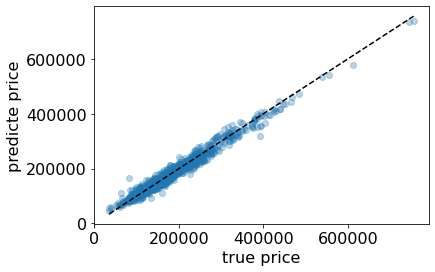

In [60]:
def scatter_results(regressor, X, y):
    plt.scatter(y, regressor.predict(X), alpha=0.3)
    grid = np.linspace(y.min(), y.max(), 1000)
    plt.plot(grid, grid, '--k');
    plt.xlabel("true price");
    plt.ylabel("predicte price");

scatter_results(gbr, X_train, y_train)

- (First off, this looks way better that linear regression from last time)
- Notice how the points tend to fall on both sides of the line.
- When we create the `GradientBoostingRegressor` we can set it to quantile regression - watch this!

In [58]:
gbr_90 = make_pipeline(preprocessing, GradientBoostingRegressor(loss='quantile', alpha=0.9))

I apologize on behalf of sklearn - this is a completely different `alpha` from the `Ridge(alpha=...)` 

In [61]:
gbr_90.fit(X_train, y_train);

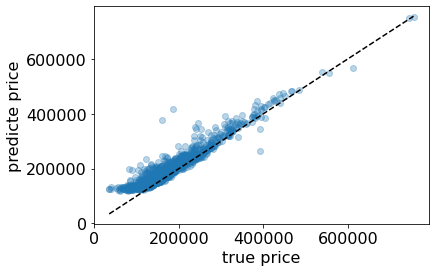

In [62]:
scatter_results(gbr_90, X_train, y_train)

- This did what we asked! The true value is below the predicted value 90% of the time.
- Put another way, this made the predictions larger.
- Note the analogy to `class_weight` here!
  - We can "fudge" the predictions.
  - This is legitimately useful, it's not "wrong".
  - We were fudging `predict_proba` for classification and `predict` for regression.
  - Our reasons for doing this are very different though (class imbalance vs. wanting prediction intervals).

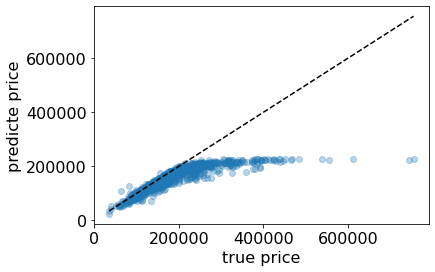

In [65]:
gbr_10 = make_pipeline(preprocessing, GradientBoostingRegressor(loss='quantile', alpha=0.1))
gbr_10.fit(X_train, y_train);
scatter_results(gbr_10, X_train, y_train)

- Yikes, those are pretty hardcore changes here.
  - Outliers are complicated (see a later lecture).
- We can use `gbr_90` and `gbr_10` to get us prediction intervals.

In [66]:
X_test[:1]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
148,60,RL,NaN,9505,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal


In [75]:
gbr.predict(X_test[:1])

array([226642.84955845])

In [76]:
gbr_90.predict(X_test[:1])

array([245858.94185702])

In [77]:
gbr_10.predict(X_test[:1])

array([197907.73343569])

- There we go, our prediction is \\$227k, with a range from \\$198k to \\$246k !
- We can plot this for a few cases:

In [110]:
def plot_intervals(mid, low, hi, X, y):
    mid_pred = mid.predict(X)
    plt.errorbar(y, mid_pred, np.abs(np.vstack((low.predict(X), hi.predict(X)))-mid_pred), fmt='.');

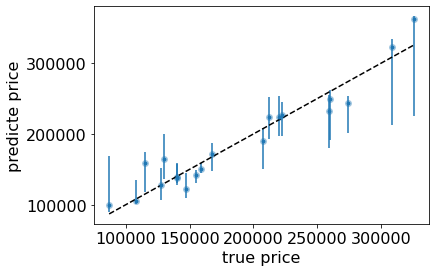

In [111]:
scatter_results(gbr, X_test[:20], y_test[:20])
plot_intervals(gbr, gbr_10, gbr_90, X_test[:20], y_test[:20])

- We can see the error bars are quite large here! 
- The decision here is domain specific - again a human factor.
- But you could try smaller intervals using, say, 0.75 and 0.25 instead of 0.9 and 0.1:

In [92]:
gbr_25 = make_pipeline(preprocessing, GradientBoostingRegressor(loss='quantile', alpha=0.45)).fit(X_train, y_train);
gbr_75 = make_pipeline(preprocessing, GradientBoostingRegressor(loss='quantile', alpha=0.55)).fit(X_train, y_train);

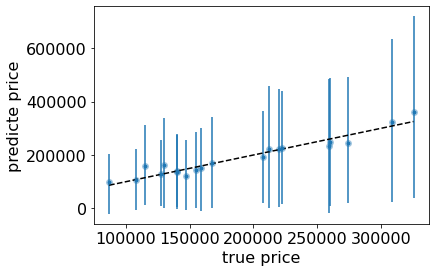

In [93]:
scatter_results(gbr, X_test[:20], y_test[:20])
plt.errorbar(y_test[:20], gbr.predict(X_test[:20]), np.vstack((gbr_25.predict(X_test[:20]), gbr_75.predict(X_test[:20]))), fmt='.');

In [105]:
np.vstack((gbr_25.predict(X_test[:20]), gbr_75.predict(X_test[:20])))

array([[212772.78305472, 107229.14948944, 153218.14996416,
        228986.62084448, 138721.46100256, 264983.75289654,
        335224.13662911, 132344.63990003, 145559.05113369,
        135847.66658232, 154096.14720024, 232213.5634819 ,
        144329.73124956, 115306.95126042, 238442.07117482,
        178776.20515476, 153752.93124799, 337266.88020747,
        211821.52908811, 176777.66924515],
       [214307.76629475, 107981.95285336, 164575.40860387,
        231671.40930711, 142228.05726964, 261964.10218166,
        340312.10447176, 133650.69554756, 145115.15153826,
        132755.07338697, 153727.58153615, 241620.25407648,
        153595.959252  , 113621.55045487, 238467.50478641,
        190648.44053447, 152368.93212155, 340325.8452029 ,
        221366.30107789, 168964.44395101]])

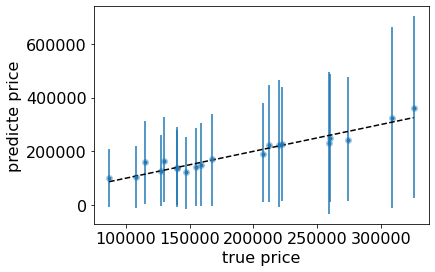

In [104]:
gbr_25 = make_pipeline(preprocessing, LGBMRegressor(objective='quantile', alpha=0.501)).fit(X_train, y_train);
gbr_75 = make_pipeline(preprocessing, LGBMRegressor(objective='quantile', alpha=0.499)).fit(X_train, y_train);
scatter_results(gbr, X_test[:20], y_test[:20])
plt.errorbar(y_test[:20], gbr.predict(X_test[:20]), np.vstack((gbr_25.predict(X_test[:20]), gbr_75.predict(X_test[:20]))), fmt='.');

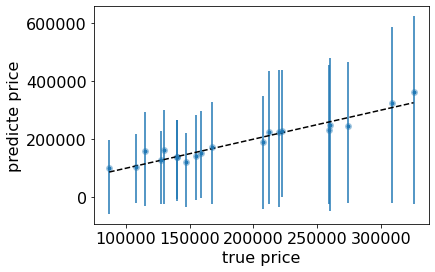

In [102]:
gbr_25 = make_pipeline(preprocessing, LGBMRegressor(objective='quantile', alpha=0.90)).fit(X_train, y_train);
gbr_75 = make_pipeline(preprocessing, LGBMRegressor(objective='quantile', alpha=0.10)).fit(X_train, y_train);
scatter_results(gbr, X_test[:20], y_test[:20])
plt.errorbar(y_test[:20], gbr.predict(X_test[:20]), np.vstack((gbr_25.predict(X_test[:20]), gbr_75.predict(X_test[:20]))), fmt='.');

In [97]:
gbr_25.predict(X_test[:1])

array([217333.45211133])

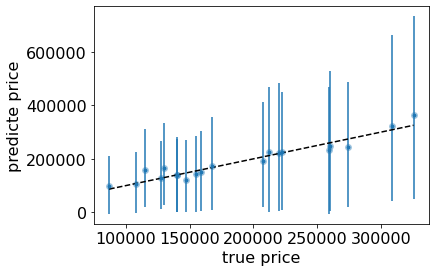

# TODO

add prediction intervals - XGBoost etc may have these already

## Feature importances: linear regression (15 min)

- Like logistic regression, with linear regression we can look at the _coefficients_ for each feature.
- Overall idea: predicted price = intercept + $\sum_i$ coefficient i $\times$ feature i.
- Let's first train on the un-logged data, for simplicity:

In [35]:
lr = Ridge()
lr.fit(X_train_imp_encode, y_train);

In [36]:
lr_coefs = pd.DataFrame(data=lr.coef_, index=df_train_imp_encode.columns, columns=["Coefficient"])
lr_coefs.head(30)

,Coefficient
LotFrontage,-2186.562754
LotArea,5245.619061
OverallQual,13686.897467
OverallCond,4726.199691
YearBuilt,1777.145405
YearRemodAdd,-408.563972
MasVnrArea,4683.880369
BsmtFinSF1,3138.711804
BsmtFinSF2,514.420585
BsmtUnfSF,-2102.343962


In [37]:
lr.intercept_

-96074.8340093139

Intuition: 

- **Increasing** `PoolArea` by 1 scaled unit **increases** the predicted price by $\sim\$3400$.
- **Increasing** `LotFrontage` by 1 scaled unit **decreases** the predicted price by $\sim\$2200$.

Does that seem reasonable?

- For `PoolArea`, yes. 
- For `LotFrontage`, that's surprising.
- Do we believe these interpretations??
  - Do we believe this is how the predictions are being computed? Yes.
  - Do we believe that this is how the world works? No. 
  - For more info, take STAT 306.

BTW, let's make sure this interpretation is true:

In [38]:
one_example = X_valid_imp_encode[:1]

In [39]:
lr.predict(one_example)

array([320510.32157338])

In [40]:
one_example_perturbed = one_example.copy()
one_example_perturbed[0,0] += 1 # add 1 to the LotFrontage

In [41]:
lr.predict(one_example_perturbed)

array([318323.7588191])

In [42]:
lr.predict(one_example_perturbed) - lr.predict(one_example)

array([-2186.56275428])

- Let's have a look at the sorted list of coefficients:

In [43]:
lr_coefs.sort_values(by="Coefficient")

,Coefficient
RoofMatl_ClyTile,-174307.016789
Condition2_PosN,-102693.648005
BedroomAbvGr_5,-21523.847732
Condition1_RRAe,-20762.820804
Neighborhood_Edwards,-19681.706418
...,...
PoolQC,33608.674121
Condition2_PosA,34268.025292
Neighborhood_NridgHt,39408.648618
Neighborhood_StoneBr,51841.282699


- What about units? `PoolArea` is in sqft, so does that mean $\$3000/\text{sqft}$? 

<br><br><br>

- No! We scaled the features.

In [44]:
scaler = feature_preprocessor.named_transformers_['scale']

- The scaler subtracted the mean and divided by the standard deviation.
- For the unit conversion, we don't care about the subtraction, but only the scaling.

In [45]:
np.sqrt(scaler.var_)

array([2.14683300e+01, 9.63462880e+03, 1.42413369e+00, 1.09904111e+00,
       2.97737968e+01, 2.07131774e+01, 1.84575195e+02, 4.70844011e+02,
       1.69751213e+02, 4.46030656e+02, 4.58874197e+02, 4.06604427e+02,
       4.30768683e+02, 4.21979265e+01, 5.33922776e+02, 5.16385274e-01,
       2.30186116e-01, 5.46413339e-01, 4.99568663e-01, 1.61098085e+00,
       6.35200462e-01, 2.36726184e+01, 7.49175078e-01, 2.15332348e+02,
       1.23911370e+02, 6.38913250e+01, 5.92775787e+01, 3.09876358e+01,
       5.63942754e+01, 4.72942137e+01, 5.81539330e+02, 1.34047839e+00])

In [46]:
lr_scales = pd.DataFrame(data=np.sqrt(scaler.var_), index=numeric_features, columns=["Scale"])
lr_scales

,Scale
LotFrontage,21.468330
LotArea,9634.628804
OverallQual,1.424134
OverallCond,1.099041
YearBuilt,29.773797
YearRemodAdd,20.713177
MasVnrArea,184.575195
BsmtFinSF1,470.844011
BsmtFinSF2,169.751213
BsmtUnfSF,446.030656


- It seems like `PoolArea` was divided by 47 sqft. 
- So $\$3400/\text{unit} \times \frac{1 \text{unit}}{47 \text{sqft}} \approx \$70/\text{sqft}$

In [47]:
lr_coefs.loc["PoolArea","Coefficient"]/lr_scales.loc["PoolArea","Scale"]

71.28612071539546

- That makes a bit more sense!
  - (But, again, don't read too much into this number without statistical training!)
- Note: we can get the same result using the scaler's `inverse_transform` function:

In [48]:
delta = scaler.inverse_transform(np.ones(len(numeric_features))) - scaler.inverse_transform(np.zeros(len(numeric_features)))
lr_scales2 = pd.DataFrame(data=delta, index=numeric_features, columns=["Scale"])
lr_scales2

,Scale
LotFrontage,21.468330
LotArea,9634.628804
OverallQual,1.424134
OverallCond,1.099041
YearBuilt,29.773797
YearRemodAdd,20.713177
MasVnrArea,184.575195
BsmtFinSF1,470.844011
BsmtFinSF2,169.751213
BsmtUnfSF,446.030656


- Actually `inverse_transform` is nicer in a way, because it generalized to any sort of scaler/normalizer you're using.

- What about the categorical features?
- We didn't scale these, so we can interpret the coefficients without this concern.
- The ordinal features are easiest:

In [49]:
ordinal_features_reg

['ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'HeatingQC',
 'KitchenQual',
 'FireplaceQu',
 'GarageQual',
 'GarageCond',
 'PoolQC']

In [50]:
lr_coefs.loc["ExterQual", 'Coefficient']

2140.9308294263988

- "Increasing by one category of exterior quality (e.g. good -> excellent) increases the predicted price by \\$2140".

- The OHE features are a bit more of a hassle.

In [51]:
categorical_features

['Condition2',
 'MSSubClass',
 'Heating',
 'Foundation',
 'MSZoning',
 'MiscFeature',
 'Street',
 'MasVnrType',
 'Neighborhood',
 'MoSold',
 'Condition1',
 'LotConfig',
 'LandSlope',
 'Electrical',
 'PavedDrive',
 'Utilities',
 'RoofStyle',
 'RoofMatl',
 'SaleCondition',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'LandContour',
 'BldgType',
 'Exterior1st',
 'SaleType',
 'Exterior2nd',
 'GarageFinish',
 'GarageType',
 'Alley',
 'CentralAir',
 'HouseStyle',
 'LotShape']

In [52]:
lr_coefs_landslope = lr_coefs[lr_coefs.index.str.startswith("LandSlope")]
lr_coefs_landslope

,Coefficient
LandSlope_Gtl,-41.313220
LandSlope_Mod,6071.762489
LandSlope_Sev,-6030.449270


- We can talk about switching from one of these categories to another by picking a "reference" category:

In [53]:
lr_coefs_landslope - lr_coefs_landslope.loc["LandSlope_Gtl"]

,Coefficient
LandSlope_Gtl,0.000000
LandSlope_Mod,6113.075709
LandSlope_Sev,-5989.136050


- So, going from a gentle slope to a moderate slope would increase the predicted price by \\$6113.
- And going from a gentle slope to a severe slope would decrease the predicted price by \\$5989.

Be a bit careful here:

- If you did `drop='first'` (we didn't) then you already have a reference class, and all the values are with respect to that one.

- The interpretation depends on whether we did `drop='first'`, hence the hassle.
- Here, we did not. 

In [54]:
lr_coefs.sort_values(by="Coefficient")

,Coefficient
RoofMatl_ClyTile,-174307.016789
Condition2_PosN,-102693.648005
BedroomAbvGr_5,-21523.847732
Condition1_RRAe,-20762.820804
Neighborhood_Edwards,-19681.706418
...,...
PoolQC,33608.674121
Condition2_PosA,34268.025292
Neighborhood_NridgHt,39408.648618
Neighborhood_StoneBr,51841.282699


- "If the roof is made of clay or tile, the predicted price is \\$174k less" ?
- It would have been easier to interpret had we used `drop='first'` because then we'd have a reference. 

#### Interpretation in log space

- As mentioned last class, if we log-transform the targets then the interpretation changes.

In [55]:
lr_log = Ridge()
lr_log.fit(X_train_imp_encode, y_train_log);

In [56]:
lr_log_coefs = pd.DataFrame(data=lr_log.coef_, index=df_train_imp_encode.columns, columns=["Coefficient"])
lr_log_coefs.head(30)

,Coefficient
LotFrontage,-0.005665
LotArea,0.015757
OverallQual,0.066756
OverallCond,0.036968
YearBuilt,0.038590
YearRemodAdd,0.004109
MasVnrArea,0.004485
BsmtFinSF1,0.003414
BsmtFinSF2,0.008255
BsmtUnfSF,-0.008999


- We keep the intuition that positive coefficients make the predicted price go up, negative coefficients make it go down.
- If we increase `PoolArea` by 1, then we increase the **log** predicted price by 0.003.
- What does it mean to increase the log of something by $x$?

log(new) = log(old) + $x$

Take exp of both sides:

new = old  $\times \exp(x)$

So, increasing `PoolArea` by 1 means we _multiply_ the predicted price by

In [57]:
np.exp(lr_log_coefs.loc["PoolArea", "Coefficient"])

1.0028931043770528

And, increasing `LotFrontage` by 1 means we _multiply_ the predicted price by

In [58]:
np.exp(lr_log_coefs.loc["LotFrontage", "Coefficient"])

0.9943512217771416

(Advanced note) For those familiar with Taylor expansions, you will know that when $x$ is small then $\exp(x)\approx 1+x$, which is what you're seeing here. But in general we might have big coefficients and this approximation is not helpful to think about.

Let's test this out!

In [59]:
one_example = X_valid_imp_encode[:1]

In [60]:
np.exp(lr_log.predict(one_example))

array([327891.95111023])

In [61]:
one_example_perturbed = one_example.copy()
one_example_perturbed[0,0] += 1 # add 1 to the LotFrontage

In [62]:
np.exp(lr_log.predict(one_example_perturbed))

array([326039.76219735])

In [63]:
np.exp(lr_log.predict(one_example_perturbed)) / np.exp(lr_log.predict(one_example))

array([0.99435122])

- So we can say something like, "Increasing the pool area by 47 sq ft causes the predicted price to go up by around 0.3%".
- Again, I am being careful to say "predicted price" instead of price, because we're just talking about our model, not the world.

## Break (5 min)

<br><br><br>

Reminder: resume recording

## Feature importances: beyond linear models (20 min)

#### Why model interpretability? 

- Ability to interpret ML models is crucial in many applications such as banking, healthcare, and criminal justice.
- It can be leveraged by domain experts to diagnose systematic errors and underlying biases of complex ML systems. 
- One problem is that often simple models are interpretable but not accurate.
  - (The previous example, where `Ridge` performed well, notwithstanding!)
- But more complex models, like random forests, are less interpretable.
- However, some modern tools can help us interpret feature importances for these models.
- There is more to interpretability than feature importances, but it's a good start!

#### Model interpretability 

- We will be looking at two ways for model interpretability. 
    - sklearn `feature_importances_`
    - [SHAP](https://github.com/slundberg/shap)

In [79]:
rf = RandomForestRegressor(random_state=111)
rf.fit(X_train_imp_encode, np.log(y_train));

In [80]:
rf.feature_importances_;

In [81]:
rf_importances = pd.DataFrame(data=rf.feature_importances_, index=df_train_imp_encode.columns, columns=["Importance"])
rf_importances.sort_values(by="Importance")

,Importance
MiscFeature_TenC,0.000000e+00
Condition2_PosA,0.000000e+00
KitchenAbvGr_3,0.000000e+00
Utilities_AllPub,0.000000e+00
Condition2_RRAe,3.782311e-09
...,...
BsmtFinSF1,2.525542e-02
1stFlrSF,2.539890e-02
TotalBsmtSF,4.267111e-02
GrLivArea,9.596270e-02


- Unlike the linear model coefficients, `feature_importances_` do not have a sign!
  - They tell us about importance, but not an "up or down".
  - Indeed, increasing a feature may cause the prediction to first go up, and then go down.
  - This cannot happen in linear models, because they are linear.
- We could compare with the absolute value of the coefficients from Ridge:

In [82]:
lr_tuned_log = Ridge(alpha=100)
lr_tuned_log.fit(X_train_imp_encode, np.log(y_train));

In [83]:
lr_tuned_log_coefs = pd.DataFrame(data=lr_tuned_log.coef_, index=df_train_imp_encode.columns, columns=["Coefficient"])
lr_tuned_log_coefs.abs().sort_values(by="Coefficient")

,Coefficient
Exterior1st_ImStucc,0.000172
MiscFeature_Gar2,0.000177
MSSubClass_85,0.000179
Condition2_Artery,0.000203
MasVnrType_?,0.000204
...,...
BsmtQual,0.033383
OverallCond,0.039747
GrLivArea,0.041132
GarageCars,0.043084


- Both models agree that overall quality is by far the most important feature (makes sense!).
- Note: we should not be comparing the actual numbers, e.g. 0.59 from random forest vs. 0.08 from linear regression.

- These values tell us globally about which features are importants.
- But what if you want to explain a _specific_ prediction. 
- Some fancier tools can help us do this.

#### SHAP  (SHapley Additive exPlanations)

- A sophisticated measure of the contribution of each feature.
- For more detail, see [GitHub repo](https://github.com/slundberg/shap) and [paper](https://arxiv.org/pdf/1705.07874.pdf).
- We won't go in details. You may refer to  if you are interested to know more. 

In [84]:
explainer = shap.TreeExplainer(rf)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


We'll compute the SHAP values on the training set (but could do it for other data):

In [85]:
X_train_imp_encode.shape

(1051, 288)

In [86]:
shap_values = explainer.shap_values(X_train_imp_encode) # Warning: takes a long time

This is just a numpy array:

In [87]:
shap_values.shape

(1051, 288)

In [88]:
X_train_imp_encode.shape

(1051, 288)

In [89]:
shap.initjs()

In [90]:
df_train_imp_encode.head(1)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Typ,Fence_?,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw
1341,-0.165978,0.338699,-0.062802,-0.505587,1.048406,0.927764,-0.577947,0.791412,-0.284437,-0.622612,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [91]:
rf.predict(X_train_imp_encode)[0]

11.939096301012096

In [92]:
shap.force_plot(explainer.expected_value, shap_values[0], df_train_imp_encode.iloc[0])

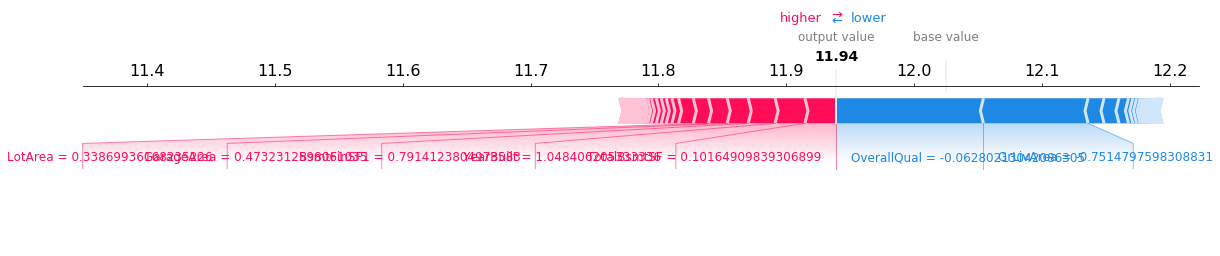

In [93]:
shap.force_plot(explainer.expected_value, shap_values[0], df_train_imp_encode.iloc[0], matplotlib=True)

Above: for this particular training example, we can see the main factors pushing it from the base value (average over the dataset) to this particular prediction. 

Note: a nice thing about SHAP values is that the feature importances sum to the prediction:

In [100]:
rf.predict(X_train_imp_encode)[0]

11.939096301012096

In [102]:
X_train_imp_encode.shape

(1051, 288)

In [105]:
shap_values[0].sum() + explainer.expected_value

11.93909630101211

This is the case for classification as well, but for the "raw model output" rather than the probability itself, because the SHAP values do not necessarily sum to something between 0 and 1.

In [94]:
# shap.force_plot(explainer.expected_value, shap_values[:100], df_train_imp_encode.iloc[:100])

In [95]:
# shap.force_plot(explainer.expected_value, shap_values[:100], df_train_imp_encode.iloc[:100], matplotlib=True)

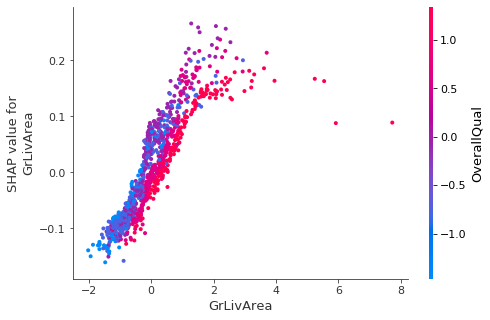

In [96]:
shap.dependence_plot("GrLivArea", shap_values, df_train_imp_encode)

- When `GrLivArea` (above grade living area) is increase, the shap value also increases -> that makes sense.
- But this type of plot also allows us to visualize non-linear or even non-monotonic behaviours.
- Note: shap automatically selects another feature -- in this case `OverallQual` -- for colouring.

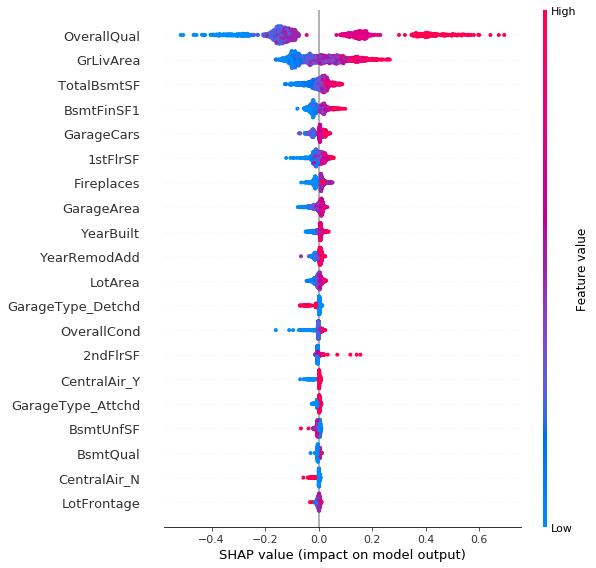

In [97]:
shap.summary_plot(shap_values, df_train_imp_encode)

- This plot orders features by importance (average SHAP value magnitude).
- Each example is drawn.
- We can see again that the prediction is higher when `OverallQual` is higher.
- There's also a summary of the summary:

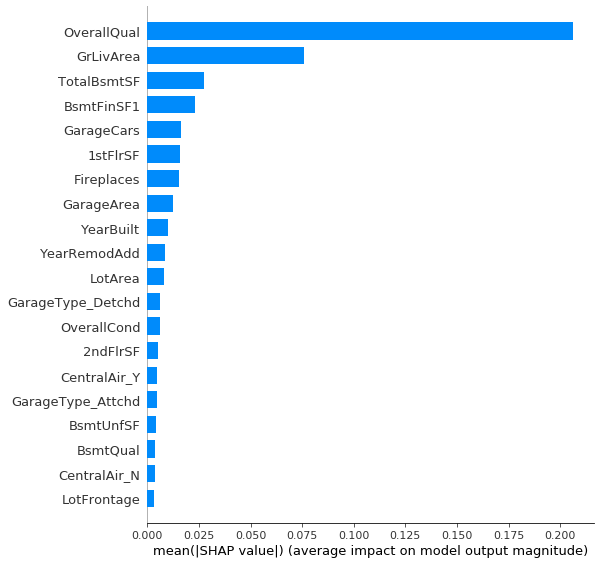

In [98]:
shap.summary_plot(shap_values, df_train_imp_encode, plot_type="bar")

Going back to the `feature_importances_`, we see something similar:

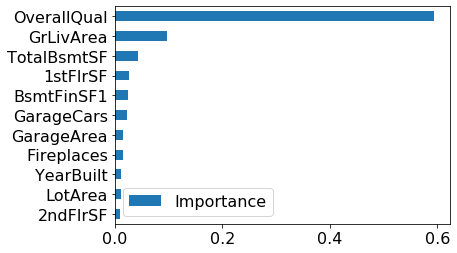

In [99]:
rf_importances.sort_values(by="Importance", ascending=False)[10::-1].plot.barh();

(Note: pandas has some built-in rudimentary plotting functionalities, which are quite convenient at times.) 

#### Other tools

- [ELI5](https://github.com/TeamHG-Memex/eli5) is another related package.
- [lime](https://github.com/marcotcr/lime) is yet another.

If you're not already impressed, keep in mind:

- So far we've only used sklearn models.
- Most sklearn models have some built-in measure of feature importances.
- On many tasks we need to move beyond sklearn, e.g. LightGBM, deep learning.
  - Not sure yet how much of that we'll do in this course.
- These tools work on other models as well, which makes them extremely useful.

#### Why do we want this information?

Possible reasons:

- Identify features that are not useful and maybe remove them.
- Get guidance on what new data to collect.
  - New features related to useful features -> better results.
  - Don't bother collecting useless features -> save resources.
- Help explain why the model is making certain predictions. 
  - Debugging, if the model is behaving strangely.
  - Regulatory requirements.
  - Fairness / bias.
- And more...

## Feature importances True/False (15 min)

1. If the first coefficient is 5, that means increasing your first feature by 1 increases the prediction by 5.
1. With linear models, increasing a feature value always impacts the prediction in the same direction; with other models, this may not be the case.
2. Since the `PoolArea` has a positive coefficient, expanding my pool will get me a higher price when I sell my house.


1. scikit-learn's feature importances only pertain to the training data. 
2. SHAP values only pertain to the training data.
3. Based on the plot below, newer houses tend to cost more than older houses.
4. Based on the plot below, age is less important for higher quality houses than for lower quality houses.  

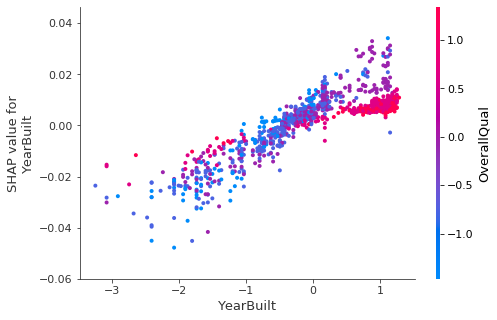

In [101]:
shap.dependence_plot("YearBuilt", shap_values, df_train_imp_encode)

# TODO

add SHAP for ensembles:

Aside: although, we don't lose all hope at interpretability - for example, we can use SHAP with `KernelExplainer` instead of `TreeExplainer`:

In [55]:
explainer = shap.KernelExplainer(averaging_model.predict, shap.sample(df_train_imp_encode, 50))
# Note: shap.sample makes the code run faster by sub-sampling the training data

In [56]:
shap_values = explainer.shap_values(df_valid_imp_encode.iloc[0])

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


In [57]:
shap.initjs()

In [58]:
shap.force_plot(explainer.expected_value, shap_values, df_valid_imp_encode.iloc[0])